In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()

import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl

In [24]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster
def adjustMask(dem, mask):
    dem_rows = dem.shape[0]
    dem_cols = dem.shape[1]
    mask_rows = mask.shape[0]
    mask_cols = mask.shape[1]
    if mask_rows > dem_rows:
        new_rows = dem_rows
        max_rows = mask_rows
    else:
        new_rows = mask_rows
        max_rows = dem_rows
    if mask_cols > dem_cols:
        new_cols = dem_cols
        max_xols = mask_cols
    else:
        new_cols = mask_cols
        max_cols = dem_cols
    
    return new_rows, new_cols, max_rows, max_cols

In [277]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data\ps')
os.chdir(location)
name = 'ps_9'
input_geotiff = gdal.Open(name+'_new.tif')
input_DEM = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_mask_geotiff = gdal.Open(name+'_c.tif')
input_MASK = np.array(input_mask_geotiff.GetRasterBand(1).ReadAsArray())

In [278]:
inset_rows, inset_cols, empty_rows, empty_cols = adjustMask(input_DEM, input_MASK)
mask_array = np.ones((empty_rows, empty_cols))
mask_array[0:inset_rows, 0:inset_cols] = input_MASK
catcment_mask = (1 - mask_array).astype('float32')

In [279]:
new_name = name + '_c_new.tif'
np_array_to_Geotiff(new_name, input_geotiff, catcment_mask, catcment_mask.dtype)#

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.


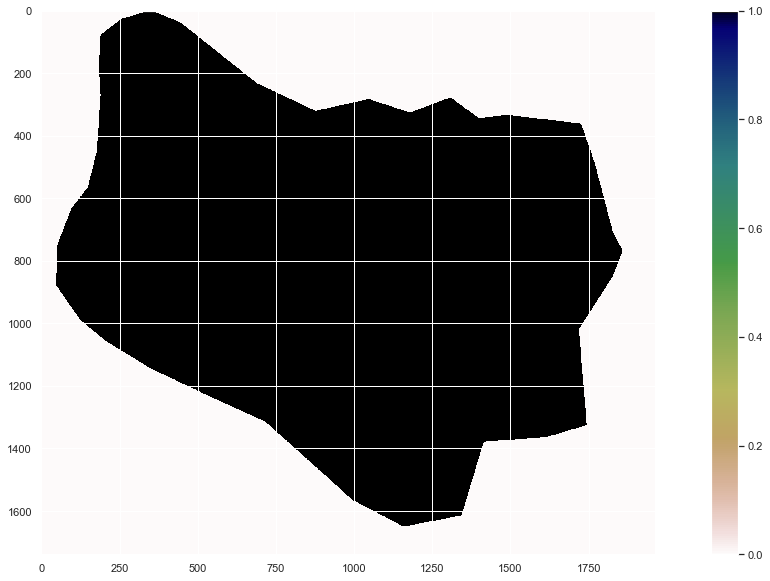

In [39]:
plt.figure(figsize=(20,10));
plt.imshow(catcment_mask, cmap="gist_earth_r")
plt.colorbar();